In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
if torch.cuda.is_available():
  print(torch.cuda.device_count())            # Numero di GPU disponibili
  print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
  print(torch.cuda.current_device())        # Device in uso al momento
  print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
  print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


In [3]:
# Carico il dataset dal drive

path = './drive/MyDrive/Materiale_Pellegrino_personal/CTU_Shuffled/CTU_Shuffled.csv'
dataset = pd.read_csv(path)

In [4]:
dataset

,StartTime,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,52:49.3,0.000540,1,<->,CON,0.0,0.0,2,131,71,flow=Background-UDP-Established,normal
1,58:54.5,0.014909,2,->,SRPA_FSPA,0.0,0.0,11,2882,1504,flow=Background-TCP-Established,normal
2,57:55.7,0.000798,1,<->,CON,0.0,0.0,2,244,182,flow=Background-UDP-Established,normal
3,56:16.4,15.302759,1,->,INT,0.0,NaN,4,336,336,flow=Background-UDP-Attempt,normal
4,53:17.7,7.843942,2,->,FSPA_SRPA,0.0,0.0,93,11846,4562,flow=Background-TCP-Established,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
31468,00:19.1,8.917003,2,->,S_SA,0.0,0.0,8,512,194,flow=Background-TCP-Established,normal
31469,59:40.5,0.038780,1,<->,CON,0.0,0.0,2,191,68,flow=To-Background-UDP-CVUT-DNS-Server,normal
31470,58:04.2,603.106201,1,->,INT,0.0,NaN,6,552,552,flow=Background-Attempt-cmpgw-CVUT,normal
31471,00:22.8,0.000550,1,<->,CON,0.0,0.0,2,128,60,flow=Background-UDP-Established,normal


In [5]:
print(Counter(dataset['multilabel']))

Counter({'normal': 31406, 'BotNet': 67})


### ***PRE-ELABORAZIONE DATI***

In [6]:
# Caratteristica temporale inutile 

dataset = dataset.drop('StartTime', axis=1)

In [7]:
dep_var = 'multilabel'
cat_names = ["Dir", "State", "Details"]
cont_names = [col for col in dataset.columns if col not in cat_names and col != dep_var]

print('Target: ', dep_var)
print('Cat: ', cat_names)
print('Cont: ', cont_names)

Target:  multilabel
Cat:  ['Dir', 'State', 'Details']
Cont:  ['Dur', 'Proto', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes']


In [8]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in cat_names:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

# Fill NaN
""" Eliminiamo dalle colonne i valori nan """ 
for col in dataset.columns:
  dataset[col] = dataset[col].fillna(0)


In [9]:
dataset.head()

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,3,4,0.0,0.0,2,131,71,6,1
1,0.014909,2,0,89,0.0,0.0,11,2882,1504,4,1
2,0.000798,1,3,4,0.0,0.0,2,244,182,6,1
3,15.302759,1,0,53,0.0,0.0,4,336,336,5,1
4,7.843942,2,0,43,0.0,0.0,93,11846,4562,4,1


In [10]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [11]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=2500/len(train), random_state=0)

In [ ]:
"""Visto che il dataset è molto squilibrato lo amplio con una generazione
 randomica di dati mediante la tecnica chiamata Synthetic Minority Over-sampling Technique (SMOTE)"""
 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_sm, y_train = sm.fit_resample(train, y_train)
train = pd.DataFrame(x_sm,columns=x_train.columns)

In [21]:
train

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
0,0.000691,1.00000,3.00000,4.000000,0.0,0.0,2.000000,563.000000,75.000000,46.00000
1,0.465912,1.00000,3.00000,4.000000,0.0,0.0,2.000000,206.000000,79.000000,46.00000
2,0.016300,1.00000,3.00000,4.000000,0.0,0.0,2.000000,222.000000,79.000000,46.00000
3,0.000792,1.00000,3.00000,4.000000,0.0,0.0,2.000000,242.000000,171.000000,6.00000
4,0.000858,1.00000,3.00000,4.000000,0.0,0.0,2.000000,132.000000,72.000000,6.00000
...,...,...,...,...,...,...,...,...,...,...
26407,68.027984,2.00000,0.00000,92.000000,0.0,0.0,33.697620,20304.520036,3008.181081,27.00000
26408,73.245115,2.00000,0.00000,92.000000,0.0,0.0,75.993017,54310.342377,5406.160067,27.00000
26409,73.245149,2.00000,0.00000,92.000000,0.0,0.0,76.089712,54409.458064,5403.943529,27.00000
26410,1.441993,1.96192,0.11424,35.743361,0.0,0.0,9.695360,972.844172,528.521294,33.07616


In [22]:
test

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
25515,9.007967,2,0,97,0.0,0.0,3,186,186,3
23879,1117.668701,1,0,53,0.0,0.0,9,1566,1566,5
30298,600.000732,2,0,84,0.0,0.0,42,16148,1966,4
11375,15.279486,2,0,99,0.0,0.0,12,768,330,4
30910,0.000329,1,3,4,0.0,0.0,2,214,81,46
...,...,...,...,...,...,...,...,...,...,...
14149,0.000291,1,3,4,0.0,0.0,2,214,81,46
26095,0.000725,1,3,4,0.0,0.0,2,311,249,6
23685,0.000372,1,3,4,0.0,0.0,2,214,81,46
17685,301.679474,1,3,4,0.0,0.0,10,680,370,6


In [23]:
validation

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details
7412,0.331651,2,0,37,0.0,0.0,9,1541,699,2
23258,240.070312,2,0,79,0.0,0.0,53,36041,2286,8
29328,0.017910,1,3,4,0.0,0.0,2,215,69,46
29074,0.000271,1,3,4,0.0,0.0,2,214,81,46
17102,0.042637,1,0,53,0.0,0.0,1,203,203,1
...,...,...,...,...,...,...,...,...,...,...
13037,15.117445,1,3,4,0.0,0.0,4,666,545,6
12261,0.742693,2,0,37,0.0,0.0,11,1251,625,41
27504,0.006718,1,3,4,0.0,0.0,4,2991,60,6
14804,0.000207,1,3,4,0.0,0.0,2,197,68,46


In [25]:
#y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [26]:
#### Fase di Categorical Embeddings ###############

for col in cat_names:
  train[col] = train[col].astype('category')

embedded_cols = {n: len(col.cat.categories) for n,col in train[cat_names].items()}
print(embedded_cols)

embedded_col_names = cat_names

# Determiniamo una funzione per la dimensione dell'incorporamento, presa da una libreria 
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

{'Dir': 2050, 'State': 4637, 'Details': 4496}


[(2050, 50), (4637, 50), (4496, 50)]

### ***MODEL***

In [27]:
""" Pytorch Dataset e DataLoader
Estendiamo la Dataset classe (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class CTU_Dataset(Dataset):
    def __init__(self, X, Y, embedded_col_names):
        X = X.copy()
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = CTU_Dataset(train, y_train, embedded_col_names)
valid_ds = CTU_Dataset(validation, y_val, embedded_col_names)

In [28]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [29]:
""" I nostri dati sono suddivisi in parti continue e categoriali. Per prima cosa convertiamo le parti categoriali in vettori 
incorporanti in base alle dimensioni determinate in precedenza e le concateniamo con le parti continue per alimentare il resto della rete """ 

class CTUModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings)  #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 2)
        self.bn1 = nn.BatchNorm1d(self.n_cont, momentum=1.0)
        self.bn2 = nn.BatchNorm1d(200, momentum=1.0)
        self.bn3 = nn.BatchNorm1d(70, momentum=1.0)
        #self.emb_drop = nn.Dropout(0.6)
        self.emb_drop = nn.Dropout(0.01)
        #self.drops = nn.Dropout(0.3)
        #self.drops = nn.Dropout(0.1)
        

    def forward(self, x_cat, x_cont):
        #x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = [e(x_cat[:,0]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        #x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        #x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [30]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output = model(x1, x2)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    #print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print('ep ', i, "training loss: ", loss)
        val_loss(model, valid_dl)

In [31]:
model = CTUModel(embedding_sizes, len(cont_names))
to_device(model, device)

CTUModel(
  (embeddings): ModuleList(
    (0): Embedding(2050, 50)
    (1): Embedding(4637, 50)
    (2): Embedding(4496, 50)
  )
  (lin1): Linear(in_features=157, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=70, bias=True)
  (lin3): Linear(in_features=70, out_features=2, bias=True)
  (bn1): BatchNorm1d(7, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(70, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.01, inplace=False)
)

### ***TRAINING***

In [32]:
print('Len train: ', len(train))
print('Len test: ', len(test))

Len train:  26412
Len test:  15737


In [33]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """ 

batch_size = 2048
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=False)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [34]:
train_loop(model, epochs=100, lr=0.00005)

ep  0 training loss:  0.7432693555177061
valid loss  7.424113496398926  and accuracy  0.6448
ep  1 training loss:  0.7215596215482663
valid loss  5.891089351654053  and accuracy  0.0684
ep  2 training loss:  0.7100767962737244
valid loss  3.5315432540893554  and accuracy  0.108
ep  3 training loss:  0.7043118809779882
valid loss  3.5696074275970457  and accuracy  0.6952
ep  4 training loss:  0.7018218898383232
valid loss  2.3832775924682617  and accuracy  0.676
ep  5 training loss:  0.6997555126101072
valid loss  2.375390072250366  and accuracy  0.1444
ep  6 training loss:  0.6982428254041999
valid loss  2.1999294496536255  and accuracy  0.6744
ep  7 training loss:  0.6973801382415208
valid loss  1.7717683263778687  and accuracy  0.6828
ep  8 training loss:  0.6961891592117615
valid loss  1.6212023015975952  and accuracy  0.684
ep  9 training loss:  0.6952613666890589
valid loss  1.6523905199050903  and accuracy  0.6844
ep  10 training loss:  0.6949050503933988
valid loss  1.8288959888

### ***PREDICTION***

In [35]:
""" Effettuiamo le predizioni sul dataset di test """

test_ds = CTU_Dataset(test, np.zeros(len(test)), embedded_col_names)
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
with torch.no_grad():
    for x1,x2,y in test_dl:
        out = model(x1, x2)
        prob = F.softmax(out, dim=1)
        preds.append(prob)
        
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [36]:
y_pred

array([0, 1, 1, ..., 0, 1, 0])

### ***EVALUATION***

In [37]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({1: 15708, 0: 29})
Pred: Counter({0: 11971, 1: 3766})


In [38]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

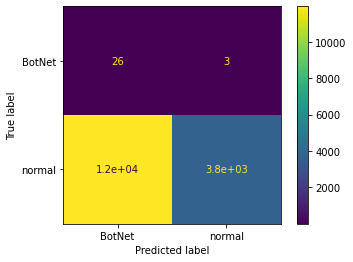

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'BotNet' : 0,
               'normal' : 1}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [40]:
print(cm)

[[   26     3]
 [11945  3763]]


In [41]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [  26 3763]
True negative:  [3763   26]
False positive:  [11945     3]
False negative:  [    3 11945]
True positive rate:  [0.89655172 0.23955946]
True negative rate:  [0.23955946 0.89655172]
False positive rate:  [0.76044054 0.10344828]
False negative rate:  [0.10344828 0.76044054]


In [42]:
print(report)

              precision    recall  f1-score   support

           0       0.00      0.90      0.00        29
           1       1.00      0.24      0.39     15708

    accuracy                           0.24     15737
   macro avg       0.50      0.57      0.20     15737
weighted avg       1.00      0.24      0.39     15737



In [43]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.24077015949672745
Precision_weighted:  0.9973660783120032
Recall_weighted:  0.24077015949672745
mcc:  0.01368194640114766
f2:  0.28383295453123786
